In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Parsing

In [4]:
#* Importation des fichiers
data_2019                           = pd.read_csv("data/ValeursFoncieres-2019-S2.txt", delimiter='|', dtype= str)
data_2020                           = pd.read_csv("data/ValeursFoncieres-2020.txt", delimiter='|', dtype= str)




#* On cat et on enlève les duplicata si il y a
data                                = pd.concat([data_2019, data_2020], ignore_index=True)
data.drop_duplicates(inplace=True)




#* On ne garde que les lignes des ventes
data                                = data[(data["Nature mutation"] == "Vente")]




#* On élimine les lignes comportant des NaN dans les catégories qui nous interessent
#* Les autres catégories ne comportent pas asser de données pour être utilisées
data                                = data.dropna(subset=["Date mutation", "Valeur fonciere", "Code departement", "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain"])




#* On clean les données et on transforme si besoin
data["Valeur fonciere"]             = data["Valeur fonciere"].str.replace(",", ".", regex= False).astype(float)
data                                = data[(data["Valeur fonciere"] < 1_500_000)]
data["Date mutation"]               = pd.to_datetime(data["Date mutation"], format="%d/%m/%Y", errors="coerce")
data["Année"]                       = data['Date mutation'].dt.year
data["Mois"]                        = data['Date mutation'].dt.month
data["Jour"]                        = data['Date mutation'].dt.day
data["Surface reelle bati"]         = data["Surface reelle bati"].str.replace(",", ".", regex= False).astype(float)
data["Nombre pieces principales"]   = data["Nombre pieces principales"].astype(int)
data["Surface terrain"]             = data["Surface terrain"].str.replace(",", ".", regex= False).astype(float)

features                            = ["Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Année", "Mois", "Jour"]
target                              = "Valeur fonciere"

X                                   = data[features]
y                                   = data[target]

categorical_features                = ["Code departement", "Type local"]
numeric_features                    = [ "Année", "Mois", "Jour", "Surface reelle bati", "Nombre pieces principales", "Surface terrain"]

preprocessor                        = ColumnTransformer(transformers= [('num', StandardScaler(), numeric_features),('cat', OneHotEncoder(handle_unknown= 'ignore'), categorical_features)])

X_processed                         = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test    = train_test_split(X_processed, y, test_size= 0.3, random_state= 42) #* keep seed to reproduce

### Visualisation des données

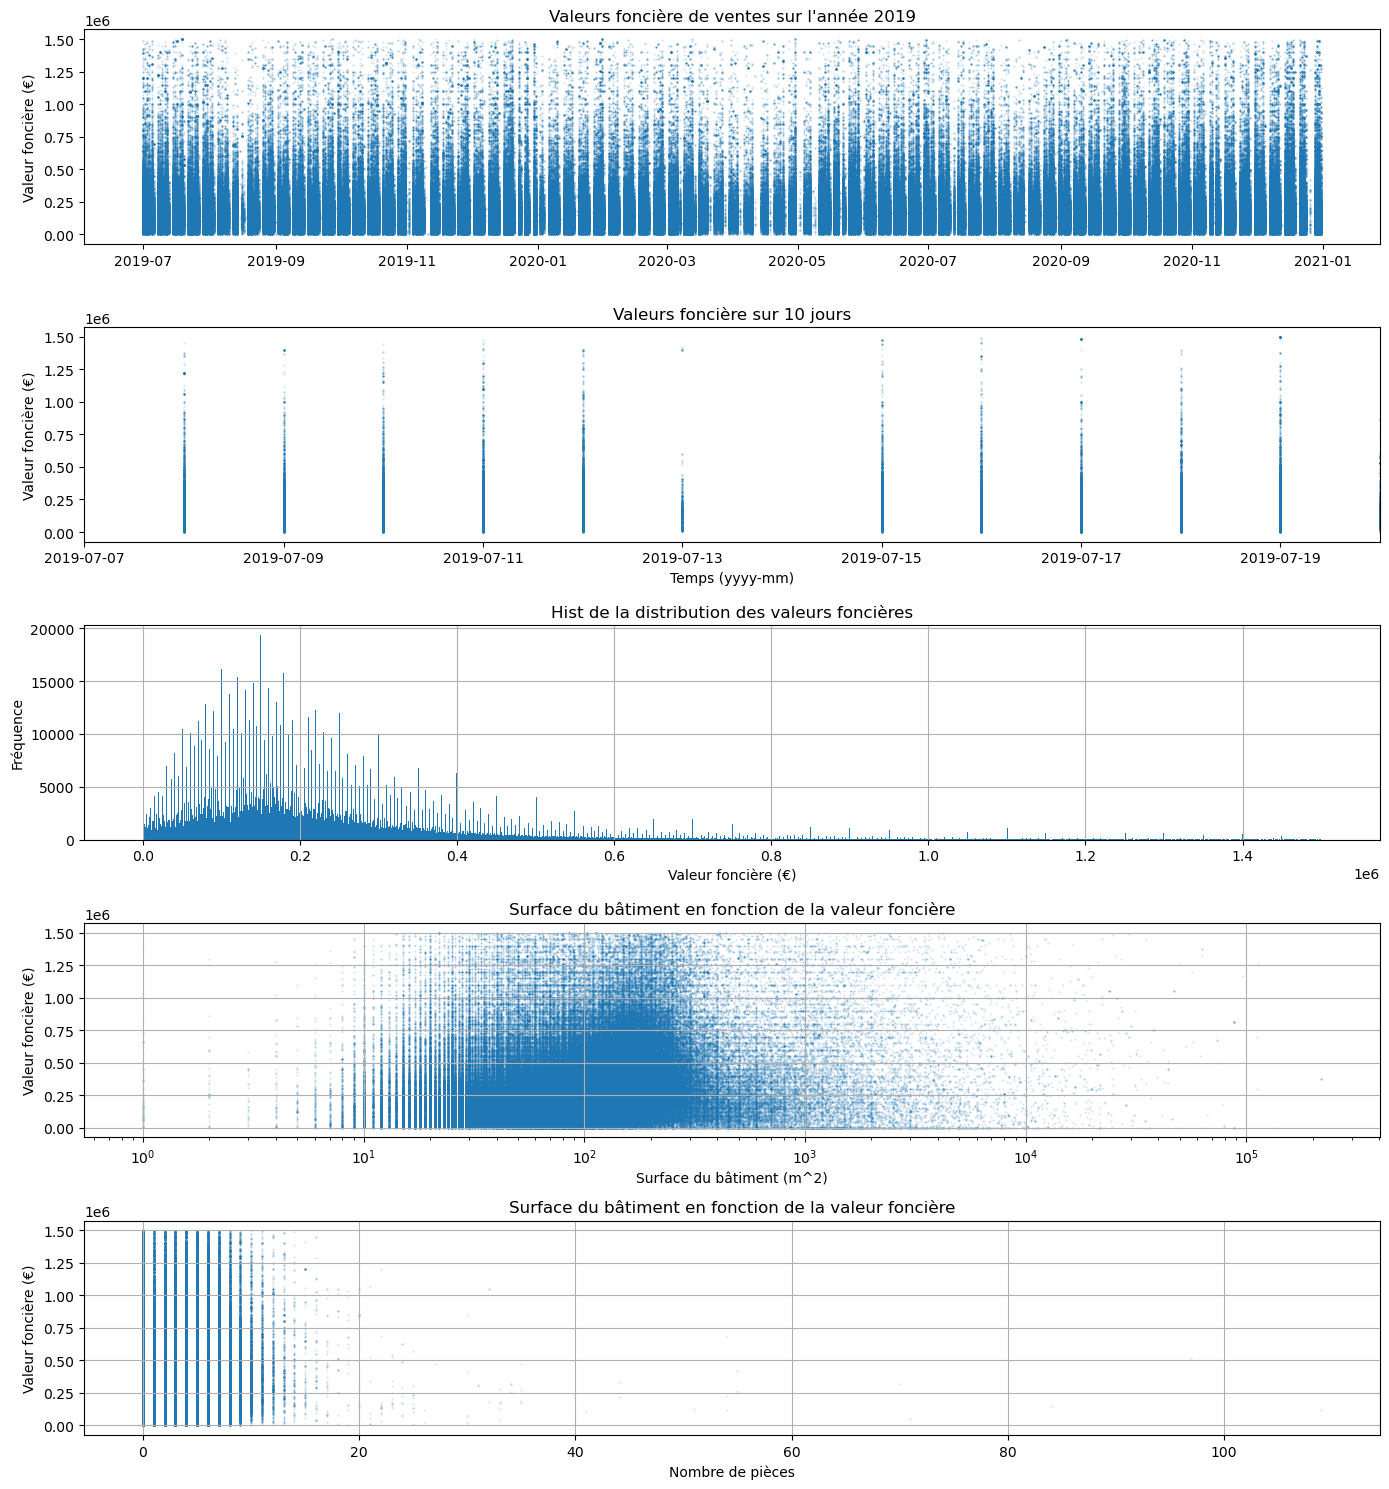

In [5]:
valeur_fonciere     = data["Valeur fonciere"]
date_vente          = data["Date mutation"]
code_departement    = data["Code departement"]
type_local          = data["Type local"]
surface_bati        = data["Surface reelle bati"]
nombre_pieces       = data["Nombre pieces principales"]
surface_terrain     = data["Surface terrain"]

plt.figure(figsize= (14, 15))

plt.subplot(511)
# plt.yscale('log')
plt.scatter(date_vente, valeur_fonciere, s= 1, alpha= .2, marker= '.')
plt.title("Valeurs foncière de ventes sur l'année 2019")
plt.ylabel("Valeur foncière (€)")

plt.subplot(512)
plt.scatter(date_vente, valeur_fonciere, s= 1, alpha= .2, marker= '.')
plt.xlabel("Temps (yyyy-mm)")
plt.ylabel("Valeur foncière (€)")
# plt.yscale('log')
plt.title("Valeurs foncière sur 10 jours")
plt.xlim(pd.Timestamp("2019-07-07"), pd.Timestamp("2019-07-20"))

plt.subplot(513)
plt.hist(valeur_fonciere, bins= int(np.sqrt(len(valeur_fonciere))))
plt.grid(True)
plt.title("Hist de la distribution des valeurs foncières")
plt.xlabel("Valeur foncière (€)")
plt.ylabel("Fréquence")

plt.subplot(514)
plt.xscale('log')
plt.scatter(surface_bati, valeur_fonciere, s= 1, alpha= .2, marker= '.')
plt.title("Surface du bâtiment en fonction de la valeur foncière")
plt.ylabel("Valeur foncière (€)")
plt.xlabel("Surface du bâtiment (m^2)")
plt.grid(True)

plt.subplot(515)
plt.scatter(nombre_pieces, valeur_fonciere, s= 1, alpha= .2, marker= '.')
plt.title("Surface du bâtiment en fonction de la valeur foncière")
plt.xlabel("Nombre de pièces")
plt.ylabel("Valeur foncière (€)")
plt.grid(True)

plt.tight_layout()
plt.show()

### Neural Network & models

In [6]:
model = Sequential()
model.add(Dense(128, activation= 'relu', input_dim= (X_train.shape[1])))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(1))
model.summary()

model.compile(optimizer= Adam(learning_rate= 0.001), loss= "mse", metrics=['mae'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,145 (86.50 KB)

 Trainable params: 22,145 (86.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train,
    batch_size=         32,
    epochs=             200,
    validation_split=   0.3,
    verbose=            1)
ev = model.evaluate(X_test, y_test)
print(ev)

plt.figure()
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

Epoch 1/200
20537/20537 ━━━━━━━━━━━━━━━━━━━━ 10s 462us/step - loss: 48468140032.0000 - mae: 144904.0312 - val_loss: 29523685376.0000 - val_mae: 110819.8672
Epoch 2/200
20537/20537 ━━━━━━━━━━━━━━━━━━━━ 9s 457us/step - loss: 29526181888.0000 - mae: 110601.2266 - val_loss: 29226518528.0000 - val_mae: 110139.3281
Epoch 3/200
20537/20537 ━━━━━━━━━━━━━━━━━━━━ 9s 457us/step - loss: 29146376192.0000 - mae: 110036.3828 - val_loss: 29177196544.0000 - val_mae: 109682.6094
Epoch 4/200
20537/20537 ━━━━━━━━━━━━━━━━━━━━ 9s 457us/step - loss: 29212936192.0000 - mae: 110184.9219 - val_loss: 29104769024.0000 - val_mae: 110216.0781
Epoch 5/200
20537/20537 ━━━━━━━━━━━━━━━━━━━━ 9s 456us/step - loss: 29032431616.0000 - mae: 109788.9219 - val_loss: 29058351104.0000 - val_mae: 109885.5625
Epoch 6/200
20537/20537 ━━━━━━━━━━━━━━━━━━━━ 9s 457us/step - loss: 29059100672.0000 - mae: 109576.4141 - val_loss: 29000443904.0000 - val_mae: 109942.5000
Epoch 7/200
20537/20537 ━━━━━━━━━━━━━━━━━━━━ 9s 455us/step - loss: 29

KeyboardInterrupt: 